In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from umap import UMAP

from csd_simulations import (
    simulate_no_csd,
    simulate_no_csd_same_z,
    simulate_no_csd_large_z,
    simulate_csd,
    simulate_csd_corr,
)
from models import (
    train_ridge,
    train_rf,
    train_mlp,
    get_metrics
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_domains = 5
n_per_domain = 50
p = 20
k = 5
noise_scale = 1.5

simulate_with_csd = True
simulate_same_z = True
correlated_noise = True

In [3]:
if k is not None:
    if simulate_with_csd:
        if correlated_noise:
            xs, ys = simulate_csd_corr(n_domains, n_per_domain, p, k, diag=0.2)
        else:
            xs, ys = simulate_csd(n_domains, n_per_domain, p, k, noise_scale)
    else:
        xs, ys = simulate_no_csd_large_z(n_domains, n_per_domain, p, k, noise_scale)
elif simulate_same_z:
    xs, ys = simulate_no_csd_same_z(n_domains, n_per_domain, p, noise_scale)
else:
    xs, ys = simulate_no_csd(n_domains, n_per_domain, p, noise_scale)

print(xs.shape)
print(xs[:5, :5])

(250, 20)
[[ 1.97523159  1.39709774 -0.21480168  0.72608814 -2.66025611]
 [ 0.7399883  -3.35895939 -1.50993939  0.74295943 -2.52660422]
 [ 2.5533883  -7.77570953 -1.46321805  5.37060107 -5.729216  ]
 [ 3.86879614 -1.67800342 -5.04246201  3.74287951 -4.48100933]
 [ 1.98065799 -5.09142173 -3.44615824  3.48068193 -4.42900411]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(250, 1)
[[ 1]
 [ 1]
 [-1]]


In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,5.235362,8.279256,0,1
1,4.699916,7.518064,0,1
2,4.523489,7.442571,0,-1
3,4.962646,7.234955,0,-1
4,4.293621,7.109100,0,-1


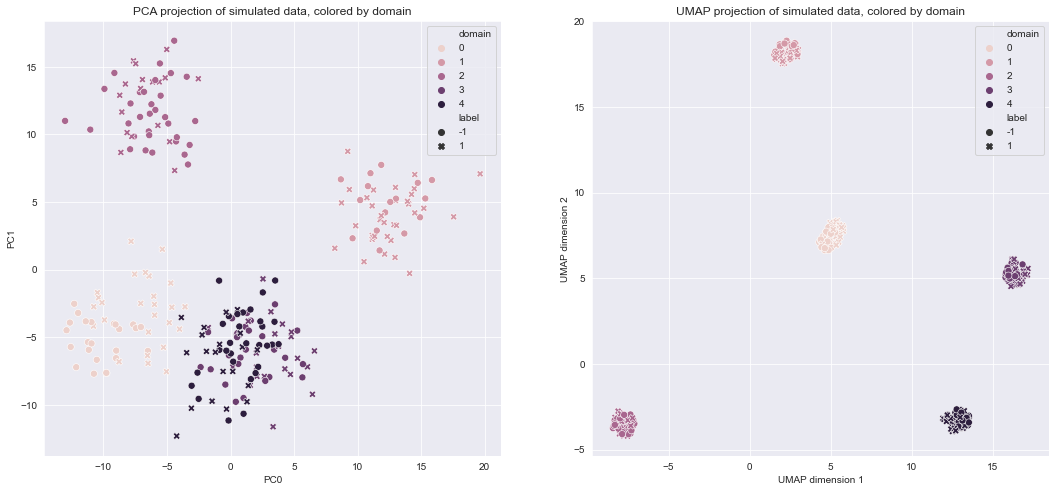

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

In [7]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs)):
    X_train, X_test = xs[train_ix, :], xs[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
 
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    params = {
        'learning_rate': [0.1, 0.01, 0.001, 5e-4, 1e-4],
        'h1_size': [100, 200, 300, 500],
        'dropout': [0.1, 0.5, 0.75],
        'weight_decay': [0, 0.1, 1, 10, 100]
    }
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.786229
1,random_forest,0,train_auroc,0.807635
2,mlp,0,train_auroc,0.963255
3,ridge,1,train_auroc,0.819444
4,random_forest,1,train_auroc,1.000000


(-0.1, 1.1)

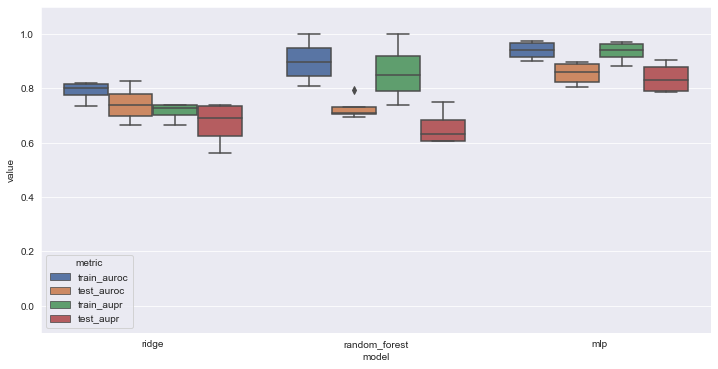

In [8]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)

In [9]:
x_covariates = pd.get_dummies(domains)
x_covariates.head()

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [10]:
xs_fixed = np.concatenate((xs, x_covariates.values), axis=1)
print(xs_fixed[:5, :]) 

[[  1.97523159   1.39709774  -0.21480168   0.72608814  -2.66025611
   -1.38863299  -2.00676098  -1.22906001  -3.48878014  -1.44462004
   -5.75519512   1.28246227  -7.30474236   1.54862409   0.99261004
    0.61030288   2.11821115   5.94697836   0.67857391   6.81756119
    1.           0.           0.           0.           0.        ]
 [  0.7399883   -3.35895939  -1.50993939   0.74295943  -2.52660422
   -6.92639474  -0.0855472    3.7297322   -0.29289522  -1.06849108
    1.63482465  -0.24347334 -11.39439385  -0.58276435   0.04224022
   -2.14448244   5.00112974   7.19672907   1.23100567   4.20862314
    1.           0.           0.           0.           0.        ]
 [  2.5533883   -7.77570953  -1.46321805   5.37060107  -5.729216
   -4.60414563   2.32251      2.1604708   -3.20186      0.49541809
   -2.11025361  -3.1845945   -3.97195901   0.88757122  -3.21988851
   -4.8232978   -1.08304872  11.47432189  -1.56481621   3.23844951
    1.           0.           0.           0.           0.    

In [11]:
# split dataset into train/test
# this time with a covariate for domain membership (this should help performance)
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs_fixed)):
    X_train, X_test = xs_fixed[train_ix, :], xs_fixed[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.796932
1,random_forest,0,train_auroc,0.849874
2,mlp,0,train_auroc,0.966232
3,ridge,1,train_auroc,0.835227
4,random_forest,1,train_auroc,0.994949


(-0.1, 1.1)

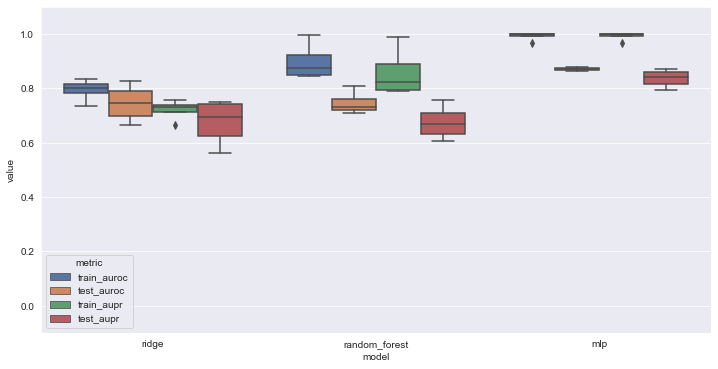

In [12]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)